# Explainability Analysis for Basic Models (4-Class)
## Understanding All Model Predictions with SHAP, LIME & Permutation Importance

---

### Models Analyzed:
1. **LogisticRegression** - Linear model (coefficients + LIME)
2. **RandomForest** - Tree ensemble (SHAP TreeExplainer + LIME)
3. **ExtraTrees** - Tree ensemble (SHAP TreeExplainer + LIME)
4. **GradientBoosting** - Boosted trees (SHAP TreeExplainer + LIME)
5. **XGBoost** - Advanced boosting (SHAP TreeExplainer + LIME)
6. **Ensemble** - Voting classifier (LIME + Permutation)

### Explainability Methods:
- **Model Coefficients:** For LogisticRegression (native interpretability)
- **SHAP (TreeExplainer):** For tree-based models
- **SHAP (LinearExplainer):** For LogisticRegression
- **LIME:** Model-agnostic local explanations (all models)
- **Permutation Importance:** Model-agnostic global importance (all models)

### Project Context:
- **Classes:** Android, Apple, Linux/Other, Windows
- **Features:** ~11 (after feature engineering)
- **Goal:** Understand what each model learned and compare their decision-making

---

## 1. Setup & Data Loading

In [ ]:
pip install shap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
pip install lime

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib
import os

# Explainability libraries
import shap
from lime import lime_tabular

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
shap.initjs()

print("✓ Libraries imported successfully")
print(f"SHAP version: {shap.__version__}")

✓ Libraries imported successfully
SHAP version: 0.49.1


### 1.1 Recreate Data Pipeline

In [3]:
print("="*70)
print("LOADING & PREPARING DATA")
print("="*70)

# Load dataset - try semicolon delimiter first, fall back to comma
DATA_PATH = "flows_ml_ready.csv"
try:
    df = pd.read_csv(DATA_PATH, sep=';')
    print("Loaded CSV with semicolon (;) delimiter")
except:
    try:
        df = pd.read_csv(DATA_PATH, sep=',')
        print("Loaded CSV with comma (,) delimiter")
    except:
        df = pd.read_csv(DATA_PATH)
        print("Loaded CSV with default delimiter")

print(f"\nOriginal shape: {df.shape}")
print(f"Original columns: {list(df.columns)}")

# Clean data (same as training notebook)
df_clean = df.copy()

# Drop source_dataset
if 'source_dataset' in df_clean.columns:
    df_clean = df_clean.drop(columns=['source_dataset'])

# Standardize column names - check what actually exists first
column_mapping = {}
possible_mappings = {
    'bytes a': 'BYTES A',
    'packets a': 'PACKETS A',
    'tcp syn size': 'TCP SYN Size',
    'tcp syn ttl': 'TCP SYN TTL',
    'tcp win size': 'TCP Win Size',
    'ua os family': 'UA OS family'
}

# Build mapping only for columns that exist
for old_name, new_name in possible_mappings.items():
    if old_name in df_clean.columns:
        column_mapping[old_name] = new_name
    # Also check if already in the target format (case-insensitive)
    elif new_name.lower() in [col.lower() for col in df_clean.columns]:
        # Find the actual column name (case-insensitive match)
        actual_col = [col for col in df_clean.columns if col.lower() == new_name.lower()][0]
        if actual_col != new_name:
            column_mapping[actual_col] = new_name

if column_mapping:
    df_clean = df_clean.rename(columns=column_mapping)
    print(f"\nRenamed columns: {column_mapping}")

# Find the target column name (case-insensitive)
target_col = None
for col in df_clean.columns:
    if col.lower() == 'ua os family':
        target_col = col
        break

if target_col is None:
    raise KeyError(f"Could not find 'UA OS family' column. Available columns: {list(df_clean.columns)}")

# If the column name is different, rename it
if target_col != 'UA OS family':
    df_clean = df_clean.rename(columns={target_col: 'UA OS family'})

# Merge classes (6 → 4)
class_mapping = {
    'ios': 'apple',
    'macos': 'apple',
    'linux': 'linux/other',
    'other': 'linux/other',
    'android': 'android',
    'windows': 'windows'
}
df_clean['UA OS family'] = df_clean['UA OS family'].replace(class_mapping)

print(f"\n4-class distribution:")
print(df_clean['UA OS family'].value_counts())

LOADING & PREPARING DATA
Loaded CSV with semicolon (;) delimiter

Original shape: (109663, 52)
Original columns: ['UA OS family', 'BYTES A', 'PACKETS A', 'TCP flags A', 'TCP SYN Size', 'TCP Win Size', 'TCP SYN TTL', 'IP ToS', 'IPv4DontFragmentforward', 'maximumTTLforward', 'tcpTimestampFirstPacketforward', 'tcpOptionWindowScaleforward', 'tcpOptionSelectiveAckPermittedforward', 'tcpOptionMaximumSegmentSizeforward', 'tcpOptionNoOperationforward', 'packetTotalCountforward', 'packetTotalCountbackward', 'flowDirection', 'flowEndReason', 'NPM_CLIENT_NETWORK_TIME', 'NPM_SERVER_NETWORK_TIME', 'NPM_SERVER_RESPONSE_TIME', 'NPM_ROUND_TRIP_TIME', 'NPM_RESPONSE_TIMEOUTS_A', 'NPM_RESPONSE_TIMEOUTS_B', 'NPM_TCP_RETRANSMISSION_A', 'NPM_TCP_RETRANSMISSION_B', 'NPM_TCP_OUT_OF_ORDER_A', 'NPM_TCP_OUT_OF_ORDER_B', 'NPM_JITTER_DEV_A', 'NPM_JITTER_AVG_A', 'NPM_JITTER_DEV_B', 'NPM_JITTER_AVG_B', 'NPM_DELAY_AVG_A', 'NPM_DELAY_AVG_B', 'NPM_DELAY_HISTOGRAM_1_A', 'NPM_DELAY_HISTOGRAM_1_B', 'TLS_CONTENT_TYPE', 'TL

### 1.2 Feature Engineering

In [4]:
def create_feature_engineering(X):
    """Create engineered features (same as training)"""
    X_eng = X.copy()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    
    # Ratio features
    if 'BYTES A' in numeric_cols and 'PACKETS A' in numeric_cols:
        X_eng['bytes_per_packet'] = X_eng['BYTES A'] / (X_eng['PACKETS A'] + 1)
    
    # Interaction features
    if 'TCP SYN TTL' in numeric_cols and 'TCP Win Size' in numeric_cols:
        X_eng['ttl_win_interaction'] = X_eng['TCP SYN TTL'] * X_eng['TCP Win Size'] / 1000
    
    if 'TCP SYN Size' in numeric_cols and 'TCP SYN TTL' in numeric_cols:
        X_eng['syn_size_ttl_interaction'] = X_eng['TCP SYN Size'] * X_eng['TCP SYN TTL']
    
    # Log transforms
    for col in ['BYTES A', 'PACKETS A']:
        if col in numeric_cols:
            X_eng[f'{col}_log'] = np.log1p(X_eng[col])
    
    # Binned features
    if 'TCP SYN TTL' in numeric_cols:
        X_eng['ttl_binned'] = pd.cut(
            X_eng['TCP SYN TTL'], 
            bins=[0, 32, 64, 128, 255, np.inf], 
            labels=['very_low', 'low', 'medium', 'high', 'very_high']
        )
        X_eng['ttl_binned'] = X_eng['ttl_binned'].astype(str)
    
    return X_eng

# Prepare features and target
X = df_clean.drop(columns=["UA OS family"]).copy()
y = df_clean["UA OS family"].copy()

# Apply feature engineering
X = create_feature_engineering(X)

print(f"\n{'='*70}")
print("FEATURE ENGINEERING")
print(f"{'='*70}")
print(f"Total features: {X.shape[1]}")
print(f"\nFeature names:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"\nClasses: {le.classes_}")


FEATURE ENGINEERING
Total features: 57

Feature names:
   1. BYTES A
   2. PACKETS A
   3. TCP flags A
   4. TCP SYN Size
   5. TCP Win Size
   6. TCP SYN TTL
   7. IP ToS
   8. IPv4DontFragmentforward
   9. maximumTTLforward
  10. tcpTimestampFirstPacketforward
  11. tcpOptionWindowScaleforward
  12. tcpOptionSelectiveAckPermittedforward
  13. tcpOptionMaximumSegmentSizeforward
  14. tcpOptionNoOperationforward
  15. packetTotalCountforward
  16. packetTotalCountbackward
  17. flowDirection
  18. flowEndReason
  19. NPM_CLIENT_NETWORK_TIME
  20. NPM_SERVER_NETWORK_TIME
  21. NPM_SERVER_RESPONSE_TIME
  22. NPM_ROUND_TRIP_TIME
  23. NPM_RESPONSE_TIMEOUTS_A
  24. NPM_RESPONSE_TIMEOUTS_B
  25. NPM_TCP_RETRANSMISSION_A
  26. NPM_TCP_RETRANSMISSION_B
  27. NPM_TCP_OUT_OF_ORDER_A
  28. NPM_TCP_OUT_OF_ORDER_B
  29. NPM_JITTER_DEV_A
  30. NPM_JITTER_AVG_A
  31. NPM_JITTER_DEV_B
  32. NPM_JITTER_AVG_B
  33. NPM_DELAY_AVG_A
  34. NPM_DELAY_AVG_B
  35. NPM_DELAY_HISTOGRAM_1_A
  36. NPM_DELAY_HIS

### 1.3 Train-Test Split & Preprocessing

In [6]:
# Same split as training
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    stratify=y_encoded, 
    random_state=42
)

print(f"Train samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")

# Get numeric features only (for SHAP/LIME)
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train_numeric)
X_test_imp = imputer.transform(X_test_numeric)

# Convert back to DataFrame
X_train_df = pd.DataFrame(X_train_imp, columns=numeric_features)
X_test_df = pd.DataFrame(X_test_imp, columns=numeric_features)

print(f"\nNumeric features: {len(numeric_features)}")
print(f"Ready for explainability analysis!")

Train samples: 87,730
Test samples: 21,933

Numeric features: 48
Ready for explainability analysis!


---
## 2. Load Trained Models

Load all models that were trained in the basic_models_training notebook.

In [7]:
# ---------------------------
# Create SMOTE-balanced training data (optional, run before training)
# ---------------------------
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from collections import Counter

# Ensure required variables exist
if 'X_train_imp' not in locals() or 'X_test_imp' not in locals() or 'y_train' not in locals():
    raise NameError("Please run the Train-Test Split & Preprocessing cell before SMOTE.")

smote = SMOTE(random_state=42, k_neighbors=5)
X_train_bal, y_train_bal = smote.fit_resample(X_train_imp, y_train)

# Create DataFrame with column names for pipelines
try:
    X_train_bal_df = pd.DataFrame(X_train_bal, columns=numeric_features)
except Exception:
    X_train_bal_df = pd.DataFrame(X_train_bal)
    print("Warning: numeric_features not found; created X_train_bal_df without column names")

print("After SMOTE resampling (train only):")
print(Counter(y_train_bal))

# Optional: scaled versions for SVM/MLP
scaler_bal = StandardScaler()
X_train_bal_scaled = scaler_bal.fit_transform(X_train_bal)
X_test_bal_scaled = scaler_bal.transform(X_test_imp)
print("Created scaled balanced sets: X_train_bal_scaled, X_test_bal_scaled")


After SMOTE resampling (train only):
Counter({np.int64(0): 34022, np.int64(4): 34022, np.int64(2): 34022, np.int64(3): 34022, np.int64(1): 34022})
Created scaled balanced sets: X_train_bal_scaled, X_test_bal_scaled


In [9]:
print("="*70)
print("LOADING/TRAINING MODELS FOR EXPLAINABILITY")
print("="*70)

import os, joblib
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

# First, try to load saved models
loaded_models = {}

# Load XGBoost if available
if os.path.exists('best_model_xgboost_4class.pkl'):
    try:
        loaded_models['XGBoost'] = joblib.load('best_model_xgboost_4class.pkl')
        print("✓ Loaded: XGBoost")
    except Exception as e:
        print(f"✗ Failed to load XGBoost: {e}")

# Load Ensemble if available
if os.path.exists('ensemble_model_4class.pkl'):
    try:
        loaded_models['Ensemble'] = joblib.load('ensemble_model_4class.pkl')
        print("✓ Loaded: Ensemble")
    except Exception as e:
        print(f"✗ Failed to load Ensemble: {e}")

print(f"\nModels loaded from disk: {len(loaded_models)}")

print("\n" + "="*70)
print("TRAINING ADDITIONAL MODELS FOR EXPLAINABILITY")
print("="*70)

# -------------------------------------------------------------------
# IMPORTANT: ColumnTransformer uses column names -> needs DataFrames
# -------------------------------------------------------------------
# Make sure we have DataFrames (fallback conversion if someone overwrote them)
if not hasattr(X_train_df, "columns"):
    raise TypeError("X_train_df must be a pandas DataFrame with column names.")
if not hasattr(X_test_df, "columns"):
    raise TypeError("X_test_df must be a pandas DataFrame with column names.")

numeric_features = X_train_df.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features)],
    remainder='drop'
)

# Define models with EXACT same parameters as training notebook
models_to_train = []

if 'LogisticRegression' not in loaded_models:
    models_to_train.append(('LogisticRegression', LogisticRegression(
        max_iter=3000, random_state=42, n_jobs=-1, C=10.0,
        solver='lbfgs', class_weight='balanced'
    )))

if 'RandomForest' not in loaded_models:
    models_to_train.append(('RandomForest', RandomForestClassifier(
        n_estimators=300, max_depth=25, min_samples_split=3,
        min_samples_leaf=1, max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    )))

if 'ExtraTrees' not in loaded_models:
    models_to_train.append(('ExtraTrees', ExtraTreesClassifier(
        n_estimators=300, max_depth=25, min_samples_split=3,
        min_samples_leaf=1, max_features='sqrt', class_weight='balanced',
        random_state=42, n_jobs=-1
    )))


# Decide training data: use SMOTE-balanced if available
if 'X_train_bal_df' in locals() and 'y_train_bal' in locals():
    train_features = X_train_bal_df
    train_labels = y_train_bal
    print("Using SMOTE-balanced training data")
else:
    train_features = X_train_df
    train_labels = y_train
    print("Using original (unbalanced) training data")

# Train missing models
for model_name, model in models_to_train:
    print(f"\nTraining {model_name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit/predict on DataFrames (NOT numpy arrays)
    pipeline.fit(train_features, train_labels)
    loaded_models[model_name] = pipeline

    y_pred = pipeline.predict(X_test_df)
    acc = accuracy_score(y_test, y_pred)
    print(f"  ✓ Trained - Accuracy: {acc:.4f} ({acc*100:.2f}%)")

print(f"\n{'='*70}")
print(f"TOTAL MODELS READY FOR EXPLAINABILITY: {len(loaded_models)}")
print(f"{'='*70}")
for name in sorted(loaded_models.keys()):
    print(f"  ✓ {name}")


LOADING/TRAINING MODELS FOR EXPLAINABILITY

Models loaded from disk: 0

TRAINING ADDITIONAL MODELS FOR EXPLAINABILITY
Using SMOTE-balanced training data

Training LogisticRegression...
  ✓ Trained - Accuracy: 0.7273 (72.73%)

Training RandomForest...
  ✓ Trained - Accuracy: 0.9793 (97.93%)

Training ExtraTrees...
  ✓ Trained - Accuracy: 0.9661 (96.61%)

TOTAL MODELS READY FOR EXPLAINABILITY: 3
  ✓ ExtraTrees
  ✓ LogisticRegression
  ✓ RandomForest


---
## 3. Permutation Importance (Model-Agnostic)

Works for ALL models - measures feature importance by randomly shuffling features.

In [10]:
from sklearn.inspection import permutation_importance
import pandas as pd

print("=" * 70)
print("PERMUTATION IMPORTANCE (All Models)")
print("=" * 70)

# Ensure we pass a DataFrame (needed because your ColumnTransformer uses column names)
if "X_test_df" in globals() and hasattr(X_test_df, "columns"):
    X_perm = X_test_df.copy()
elif "X_test_imp" in globals() and "X_train_df" in globals() and hasattr(X_train_df, "columns"):
    X_perm = pd.DataFrame(X_test_imp, columns=X_train_df.columns)
else:
    raise TypeError("Need X_test_df (DataFrame) OR X_test_imp + X_train_df.columns to build a DataFrame.")

permutation_results = {}

for model_name, model_pipeline in loaded_models.items():
    print(f"\nComputing permutation importance for {model_name}...")

    try:
        perm_importance = permutation_importance(
            model_pipeline,
            X_perm,          # FIX: DataFrame, not numpy array
            y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1,
            scoring="accuracy"
        )

        feature_names = list(X_perm.columns)

        importance_df = pd.DataFrame({
            "feature": feature_names,
            "importance_mean": perm_importance.importances_mean,
            "importance_std": perm_importance.importances_std
        }).sort_values("importance_mean", ascending=False)

        permutation_results[model_name] = importance_df

        print(f"✓ Completed for {model_name}")
        print("\nTop 5 features:")
        for r in importance_df.head(5).itertuples(index=False):
            print(f"  {r.feature:<30} {r.importance_mean:+.6f} ± {r.importance_std:.6f}")

    except Exception as e:
        print(f"✗ Error for {model_name}: {e}")

print("\n" + "=" * 70)
print("PERMUTATION IMPORTANCE COMPLETE")
print("=" * 70)


PERMUTATION IMPORTANCE (All Models)

Computing permutation importance for LogisticRegression...
✓ Completed for LogisticRegression

Top 5 features:
  TCP SYN Size                   +0.272243 ± 0.002773
  TLS_HANDSHAKE_TYPE             +0.095391 ± 0.001001
  TLS_SERVER_VERSION             +0.044604 ± 0.000474
  TLS_CIPHER_SUITE               +0.029079 ± 0.001298
  NPM_DELAY_AVG_B                +0.022715 ± 0.001042

Computing permutation importance for RandomForest...
✓ Completed for RandomForest

Top 5 features:
  TCP SYN Size                   +0.093904 ± 0.000809
  tcpOptionWindowScaleforward    +0.049847 ± 0.000687
  maximumTTLforward              +0.022017 ± 0.000718
  TCP Win Size                   +0.015543 ± 0.000666
  ttl_win_interaction            +0.006374 ± 0.000407

Computing permutation importance for ExtraTrees...
✓ Completed for ExtraTrees

Top 5 features:
  TCP SYN Size                   +0.126946 ± 0.001030
  TCP Win Size                   +0.104368 ± 0.001767
  flowDi

### 3.1 Visualize Permutation Importance Across Models

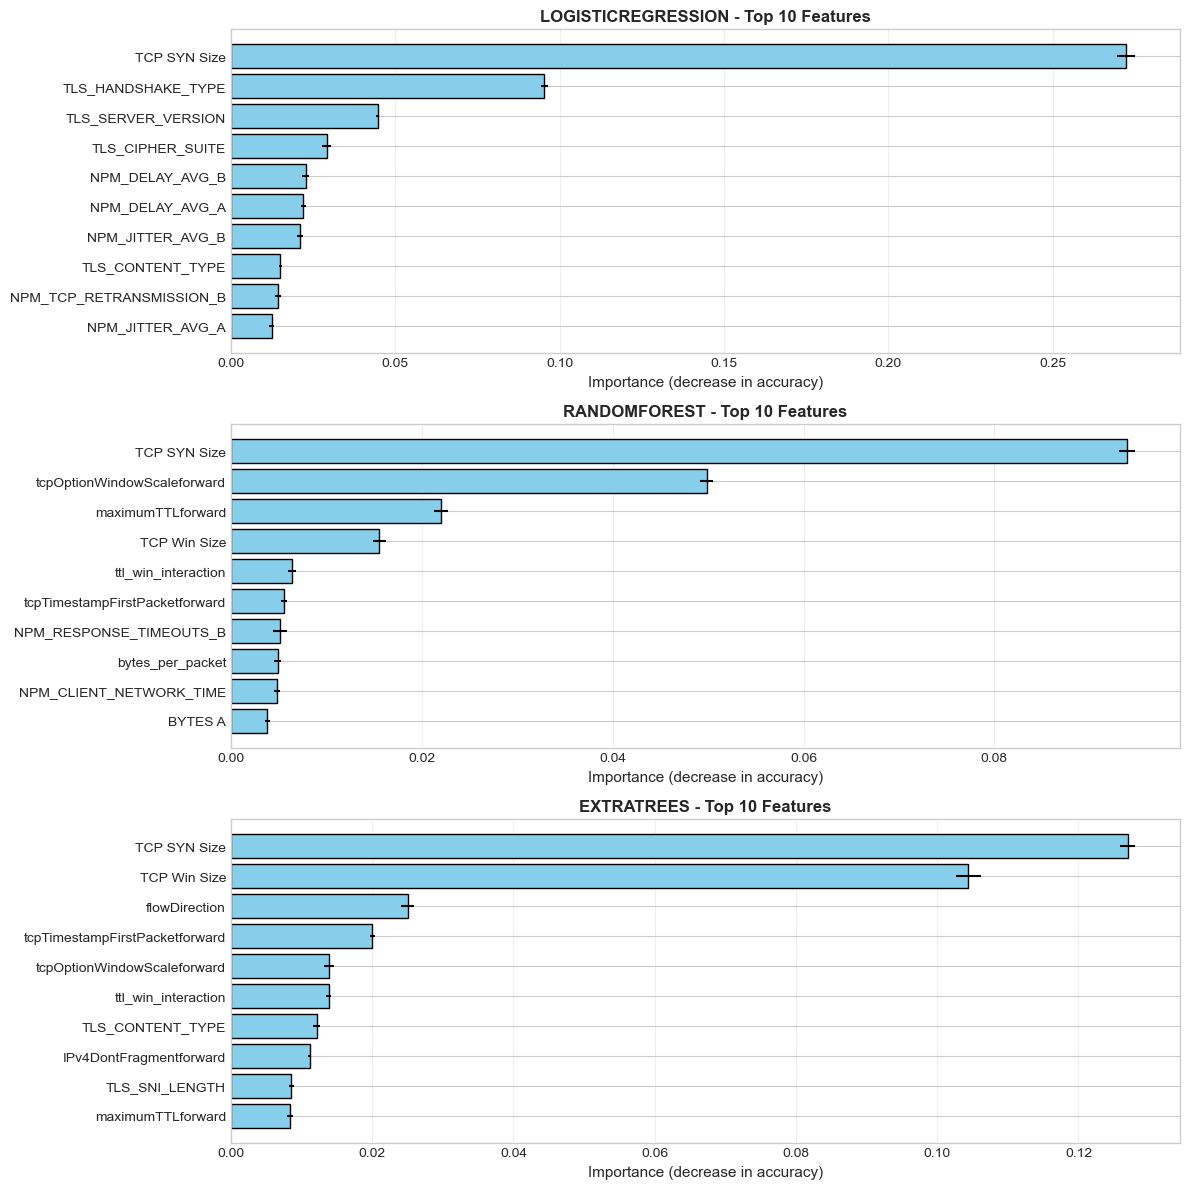


✓ Plot saved as 'permutation_importance_all_models.png'


In [11]:
if len(permutation_results) > 0:
    # Create comparison plot
    fig, axes = plt.subplots(len(permutation_results), 1, 
                             figsize=(12, 4*len(permutation_results)))
    
    if len(permutation_results) == 1:
        axes = [axes]
    
    for idx, (model_name, importance_df) in enumerate(permutation_results.items()):
        top_10 = importance_df.head(10)
        
        axes[idx].barh(range(len(top_10)), top_10['importance_mean'], 
                       xerr=top_10['importance_std'], 
                       color='skyblue', edgecolor='black')
        axes[idx].set_yticks(range(len(top_10)))
        axes[idx].set_yticklabels(top_10['feature'])
        axes[idx].set_xlabel('Importance (decrease in accuracy)', fontsize=11)
        axes[idx].set_title(f'{model_name.upper()} - Top 10 Features', 
                           fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('permutation_importance_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Plot saved as 'permutation_importance_all_models.png'")

---
## 4. LogisticRegression - Coefficients Analysis

For LogisticRegression, we can directly inspect the learned coefficients.

LOGISTICREGRESSION COEFFICIENTS ANALYSIS

Coefficient shape: (5, 48)
  - 5 classes
  - 48 features

Class: ANDROID

Top 5 positive coefficients (→ Android):
  + TCP SYN Size..................   0.0738
  + NPM_JITTER_AVG_B..............   0.0606
  + ttl_win_interaction...........   0.0508
  + tcpOptionWindowScaleforward...   0.0461
  + NPM_RESPONSE_TIMEOUTS_B.......   0.0400

Top 5 negative coefficients (← away from Android):
  - TLS_CONTENT_TYPE..............  -0.1001
  - tcpTimestampFirstPacketforward  -0.1000
  - tcpOptionMaximumSegmentSizeforward  -0.1000
  - TLS_SNI_LENGTH................  -0.0640
  - NPM_DELAY_AVG_A...............  -0.0462


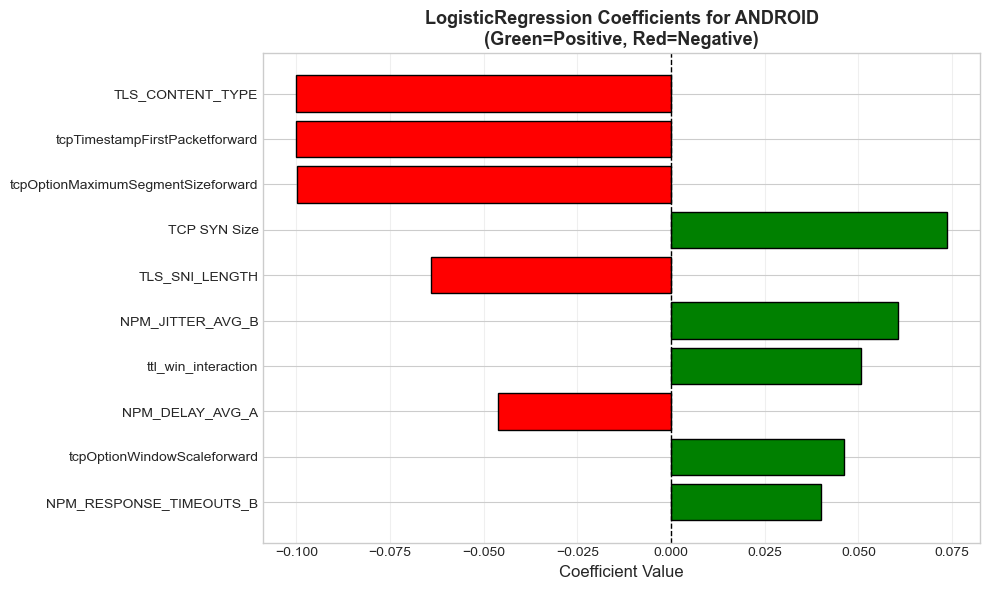


Class: LINUX

Top 5 positive coefficients (→ Linux):
  + tcpOptionMaximumSegmentSizeforward   0.0788
  + bytes_per_packet..............   0.0710
  + TCP SYN Size..................   0.0579
  + NPM_DELAY_AVG_B...............   0.0563
  + tcpTimestampFirstPacketforward   0.0552

Top 5 negative coefficients (← away from Linux):
  - ttl_win_interaction...........  -0.0812
  - NPM_CLIENT_NETWORK_TIME.......  -0.0326
  - NPM_ROUND_TRIP_TIME...........  -0.0324
  - syn_size_ttl_interaction......  -0.0323
  - tcpOptionWindowScaleforward...  -0.0309


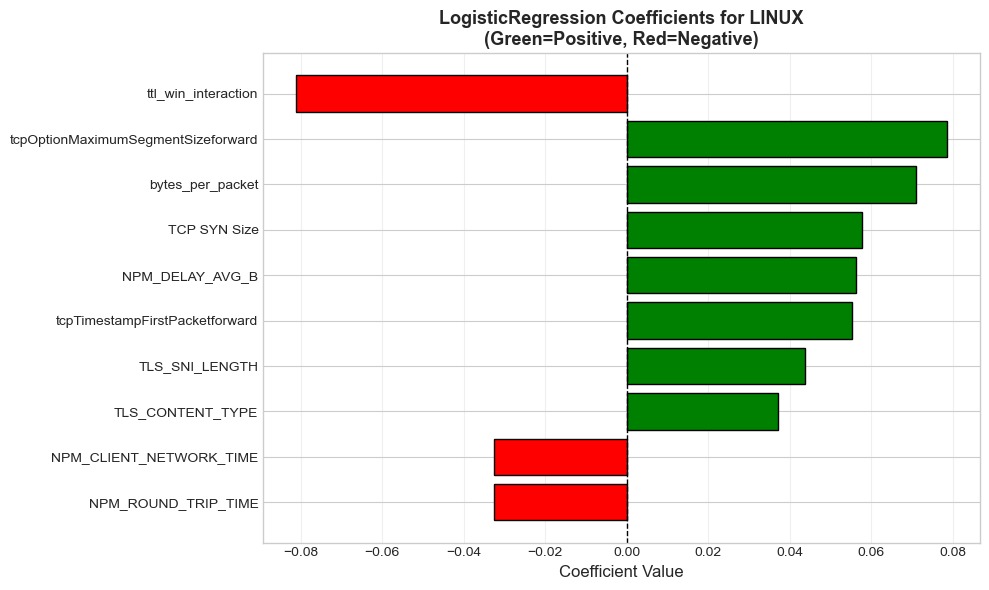


Class: OTHER

Top 5 positive coefficients (→ Other):
  + tcpOptionWindowScaleforward...   0.1172
  + NPM_CLIENT_NETWORK_TIME.......   0.1028
  + NPM_ROUND_TRIP_TIME...........   0.1022
  + TLS_SNI_LENGTH................   0.1016
  + NPM_SERVER_RESPONSE_TIME......   0.0800

Top 5 negative coefficients (← away from Other):
  - TCP SYN Size..................  -0.2041
  - ttl_win_interaction...........  -0.0828
  - NPM_RESPONSE_TIMEOUTS_B.......  -0.0726
  - BYTES A_log...................  -0.0640
  - TLS_CLIENT_KEY_LENGTH.........  -0.0569


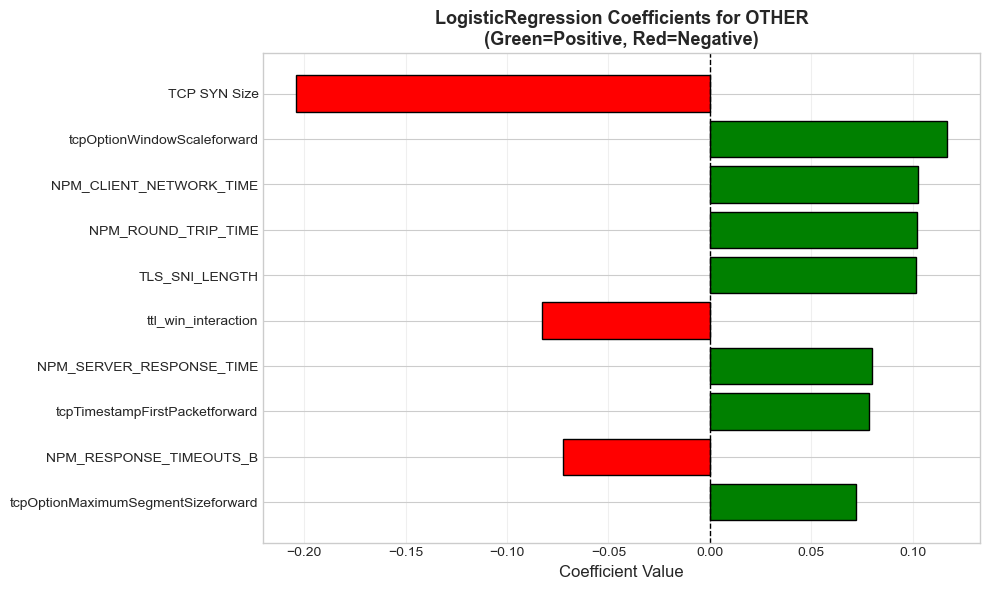


Class: WINDOWS

Top 5 positive coefficients (→ Windows):
  + ttl_win_interaction...........   0.1140
  + maximumTTLforward.............   0.0588
  + NPM_DELAY_AVG_A...............   0.0583
  + syn_size_ttl_interaction......   0.0463
  + TCP SYN TTL...................   0.0410

Top 5 negative coefficients (← away from Windows):
  - TCP SYN Size..................  -0.4413
  - NPM_CLIENT_NETWORK_TIME.......  -0.0366
  - NPM_ROUND_TRIP_TIME...........  -0.0362
  - TLS_SNI_LENGTH................  -0.0329
  - TLS_SETUP_TIME................  -0.0286


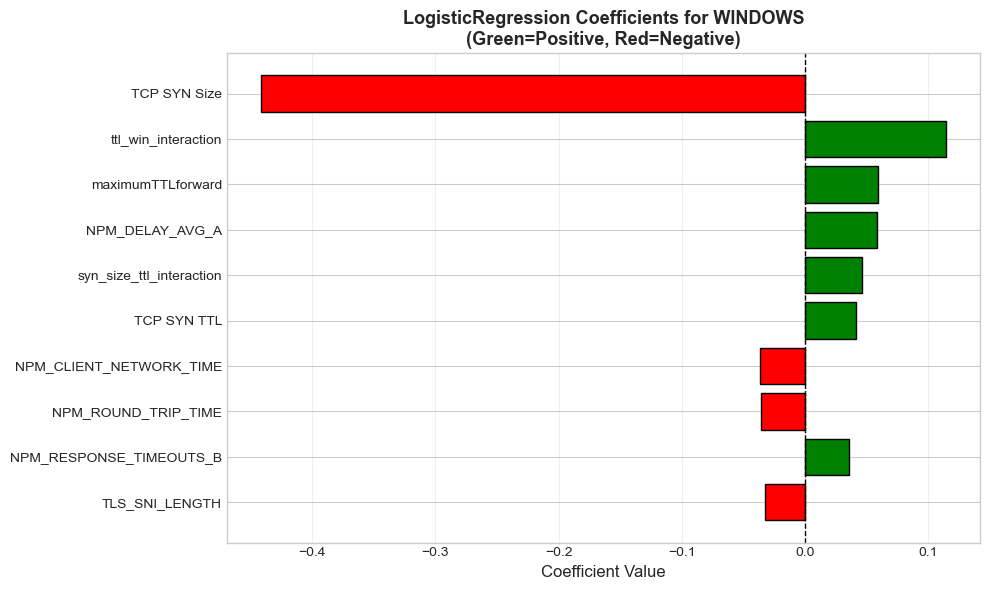


Class: IOS

Top 5 positive coefficients (→ iOS):
  + TCP SYN Size..................   0.5138
  + TLS_CLIENT_KEY_LENGTH.........   0.0427
  + TLS_CONTENT_TYPE..............   0.0418
  + NPM_JITTER_AVG_A..............   0.0391
  + NPM_DELAY_AVG_A...............   0.0338

Top 5 negative coefficients (← away from iOS):
  - tcpOptionWindowScaleforward...  -0.1071
  - tcpOptionMaximumSegmentSizeforward  -0.0508
  - TLS_SNI_LENGTH................  -0.0485
  - NPM_SERVER_RESPONSE_TIME......  -0.0406
  - tcpTimestampFirstPacketforward  -0.0393


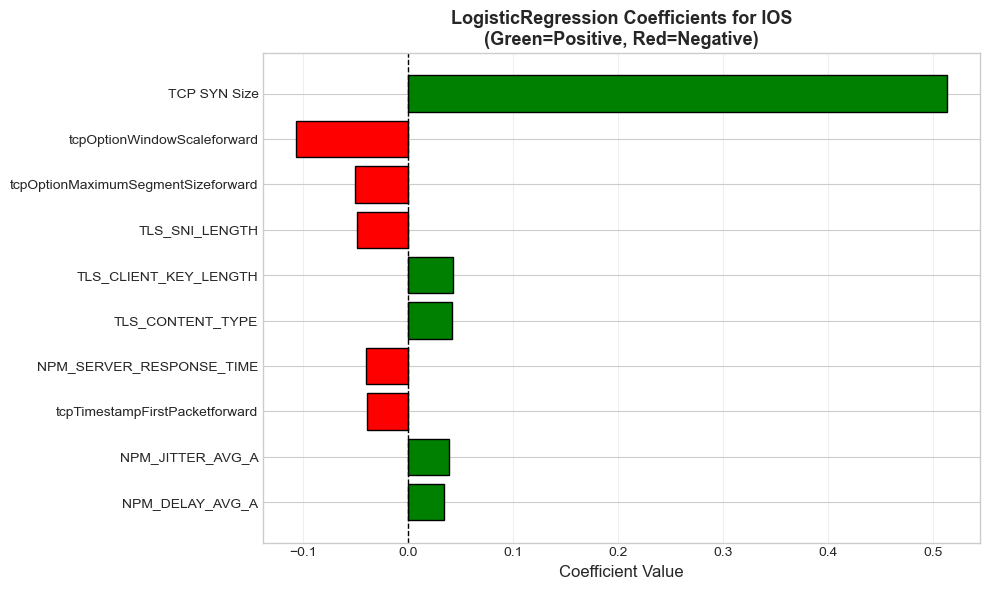


✓ Logistic coefficients analysis complete


In [12]:
# Check if LogisticRegression was loaded
logistic_model = None
for name, model in loaded_models.items():
    if 'logistic' in name.lower():
        logistic_model = model
        logistic_name = name
        break

if logistic_model is not None:
    print("="*70)
    print(f"LOGISTICREGRESSION COEFFICIENTS ANALYSIS")
    print("="*70)
    
    # Extract coefficients from pipeline
    try:
        # Get the classifier from pipeline
        if hasattr(logistic_model, 'named_steps'):
            classifier = logistic_model.named_steps['model']
        else:
            classifier = logistic_model
        
        # Get coefficients
        coefficients = classifier.coef_
        
        print(f"\nCoefficient shape: {coefficients.shape}")
        print(f"  - {coefficients.shape[0]} classes")
        print(f"  - {coefficients.shape[1]} features")
        
        # Analyze coefficients for each class
        for class_idx, class_name in enumerate(le.classes_):
            print(f"\n{'='*70}")
            print(f"Class: {class_name.upper()}")
            print(f"{'='*70}")
            
            class_coef = coefficients[class_idx, :]
            
            # Create DataFrame
            coef_df = pd.DataFrame({
                'feature': numeric_features,
                'coefficient': class_coef,
                'abs_coefficient': np.abs(class_coef)
            }).sort_values('abs_coefficient', ascending=False)
            
            print(f"\nTop 5 positive coefficients (→ {class_name}):")
            positive = coef_df[coef_df['coefficient'] > 0].head(5)
            for _, row in positive.iterrows():
                print(f"  + {row['feature']:.<30} {row['coefficient']:>8.4f}")
            
            print(f"\nTop 5 negative coefficients (← away from {class_name}):")
            negative = coef_df[coef_df['coefficient'] < 0].head(5)
            for _, row in negative.iterrows():
                print(f"  - {row['feature']:.<30} {row['coefficient']:>8.4f}")
            
            # Visualize
            plt.figure(figsize=(10, 6))
            top_10 = coef_df.head(10)
            colors = ['green' if x > 0 else 'red' for x in top_10['coefficient']]
            plt.barh(range(len(top_10)), top_10['coefficient'], color=colors, edgecolor='black')
            plt.yticks(range(len(top_10)), top_10['feature'])
            plt.xlabel('Coefficient Value', fontsize=12)
            plt.title(f'LogisticRegression Coefficients for {class_name.upper()}\n'
                     f'(Green=Positive, Red=Negative)', 
                     fontsize=13, fontweight='bold')
            plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'logistic_coefficients_{class_name}.png', dpi=300, bbox_inches='tight')
            plt.show()
        
        print(f"\n✓ Logistic coefficients analysis complete")
        
    except Exception as e:
        print(f"✗ Error analyzing coefficients: {e}")
else:
    print("⚠️  LogisticRegression model not found")

---
## 5. SHAP Analysis for Tree Models

Apply SHAP TreeExplainer to RandomForest, ExtraTrees, GradientBoosting, XGBoost.

In [13]:
print("="*70)
print("SHAP ANALYSIS FOR TREE MODELS")
print("="*70)

# Identify tree-based models
tree_models = {}
for name, model in loaded_models.items():
    if any(x in name.lower() for x in ['forest', 'tree', 'boost', 'xgb']):
        tree_models[name] = model

print(f"\nFound {len(tree_models)} tree-based models")
for name in tree_models.keys():
    print(f"  - {name}")

shap_results = {}

# Sample data for SHAP (computational efficiency)
sample_size = min(500, len(X_train_df))
np.random.seed(42)
sample_indices = np.random.choice(len(X_train_df), size=sample_size, replace=False)
X_sample = X_train_df.iloc[sample_indices]
y_sample = y_train[sample_indices]

print(f"\nUsing {sample_size} samples for SHAP computation")

SHAP ANALYSIS FOR TREE MODELS

Found 2 tree-based models
  - RandomForest
  - ExtraTrees

Using 500 samples for SHAP computation


### 5.1 Compute SHAP Values for Each Tree Model

In [14]:
for model_name, model_pipeline in tree_models.items():
    print(f"\n{'='*70}")
    print(f"SHAP Analysis: {model_name.upper()}")
    print(f"{'='*70}")
    
    try:
        # Extract the actual model from pipeline
        if hasattr(model_pipeline, 'named_steps'):
            if 'model' in model_pipeline.named_steps:
                actual_model = model_pipeline.named_steps['model']
            elif 'classifier' in model_pipeline.named_steps:
                actual_model = model_pipeline.named_steps['classifier']
            else:
                actual_model = model_pipeline.named_steps[list(model_pipeline.named_steps.keys())[-1]]
        else:
            actual_model = model_pipeline
        
        # Preprocess sample data
        if hasattr(model_pipeline, 'named_steps') and 'preprocessor' in model_pipeline.named_steps:
            X_sample_processed = model_pipeline.named_steps['preprocessor'].transform(X_sample)
            X_sample_processed = pd.DataFrame(X_sample_processed, columns=numeric_features)
        else:
            X_sample_processed = X_sample
        
        print(f"\nComputing SHAP values...")
        explainer = shap.TreeExplainer(
            actual_model,
            feature_perturbation='interventional'
        )
        
        shap_values = explainer.shap_values(X_sample_processed)
        
        shap_results[model_name] = {
            'explainer': explainer,
            'shap_values': shap_values,
            'X_sample': X_sample_processed
        }
        
        print(f"✓ SHAP computation complete")
        print(f"  Shape: {np.array(shap_values).shape if isinstance(shap_values, list) else shap_values.shape}")
        
    except Exception as e:
        print(f"✗ Error computing SHAP for {model_name}: {e}")
        continue

print(f"\n{'='*70}")
print(f"SHAP ANALYSIS COMPLETE FOR {len(shap_results)} MODELS")
print(f"{'='*70}")


SHAP Analysis: RANDOMFOREST

Computing SHAP values...
✓ SHAP computation complete
  Shape: (500, 48, 5)

SHAP Analysis: EXTRATREES

Computing SHAP values...
✓ SHAP computation complete
  Shape: (500, 48, 5)

SHAP ANALYSIS COMPLETE FOR 2 MODELS


### 5.2 SHAP Summary Plots


SHAP Summary: RANDOMFOREST


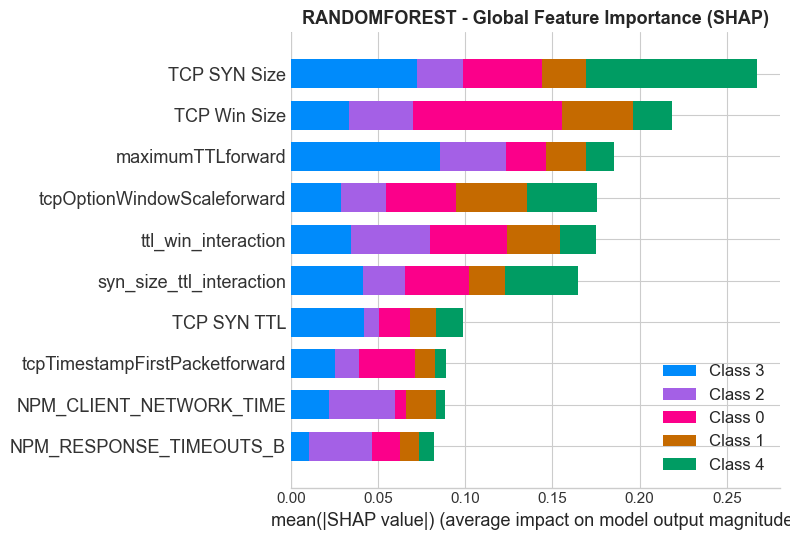

<Figure size 1000x800 with 0 Axes>

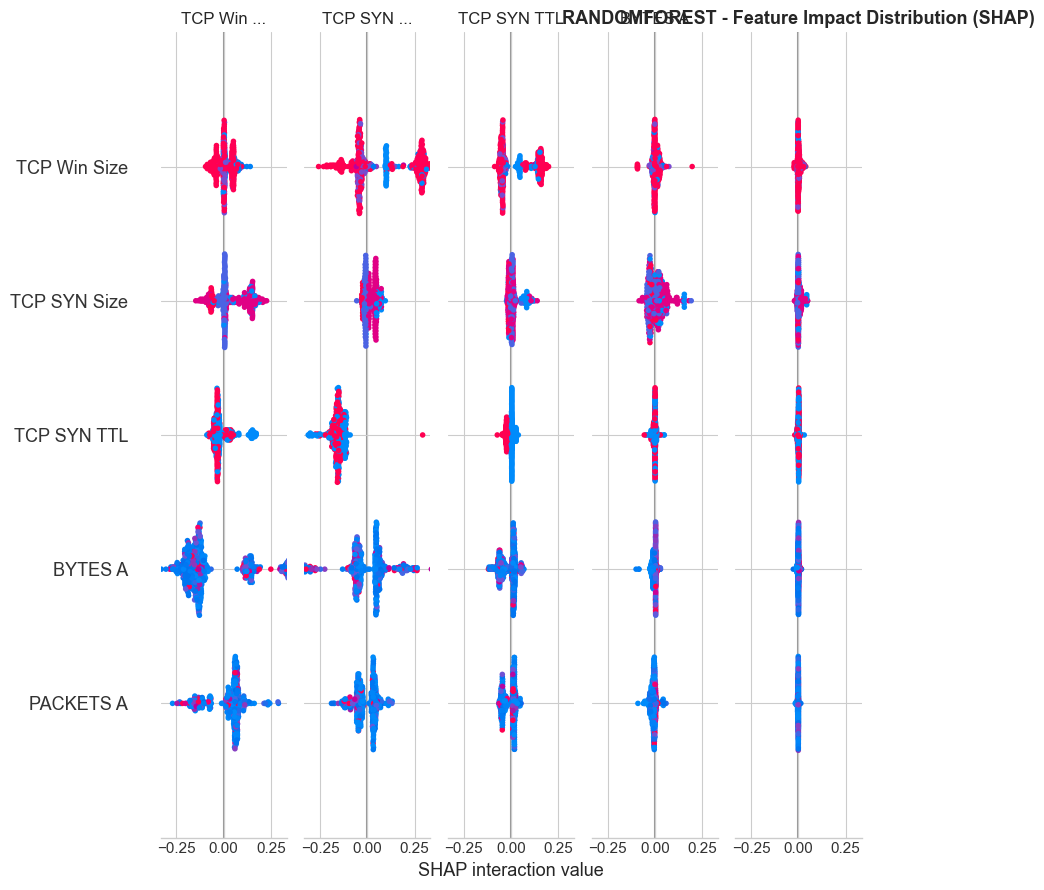

✓ SHAP plots saved

SHAP Summary: EXTRATREES


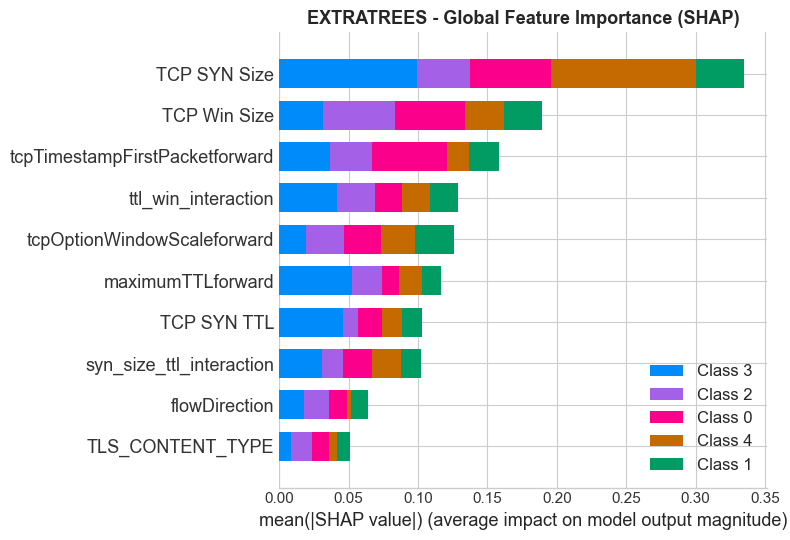

<Figure size 1000x800 with 0 Axes>

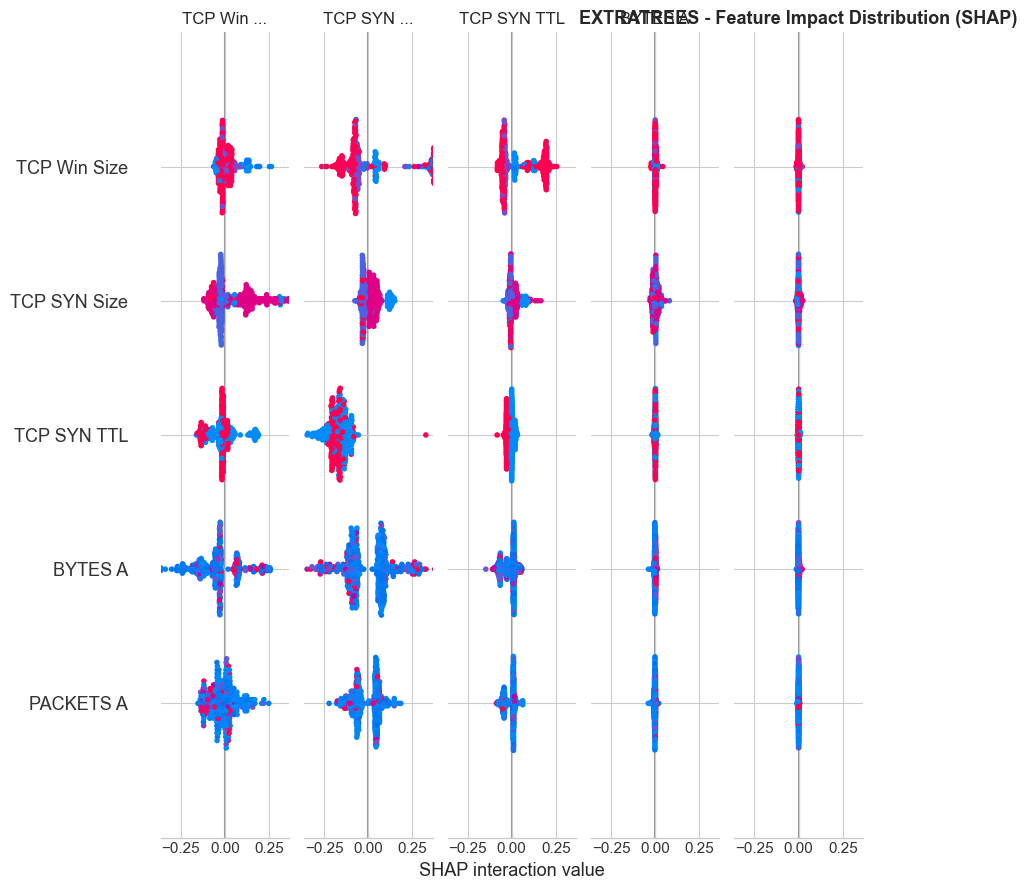

✓ SHAP plots saved


In [15]:
for model_name, shap_data in shap_results.items():
    print(f"\n{'='*70}")
    print(f"SHAP Summary: {model_name.upper()}")
    print(f"{'='*70}")
    
    try:
        shap_values = shap_data['shap_values']
        X_sample_data = shap_data['X_sample']
        
        # Global importance (bar plot)
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values,
            X_sample_data,
            plot_type="bar",
            show=False,
            max_display=10
        )
        plt.title(f'{model_name.upper()} - Global Feature Importance (SHAP)',
                 fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Beeswarm plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(
            shap_values,
            X_sample_data,
            show=False,
            max_display=10
        )
        plt.title(f'{model_name.upper()} - Feature Impact Distribution (SHAP)',
                 fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'shap_beeswarm_{model_name}.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✓ SHAP plots saved")
        
    except Exception as e:
        print(f"✗ Error creating SHAP plots for {model_name}: {e}")

---
## 6. LIME Analysis (All Models)

LIME provides local explanations for individual predictions - works with ANY model.

In [16]:
print("="*70)
print("LIME EXPLAINER SETUP")
print("="*70)

# Create LIME explainer
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_imp,
    feature_names=numeric_features,
    class_names=le.classes_,
    mode='classification',
    random_state=42
)

print(f"\n✓ LIME explainer initialized")
print(f"  Training samples: {X_train_imp.shape[0]:,}")
print(f"  Features: {len(numeric_features)}")
print(f"  Classes: {len(le.classes_)}")

LIME EXPLAINER SETUP

✓ LIME explainer initialized
  Training samples: 87,730
  Features: 48
  Classes: 5


### 6.1 LIME Explanations for Individual Predictions


LIME Explanations: LOGISTICREGRESSION

Sample #11149:
  True: Windows  |  Predicted: Windows (88.89%)


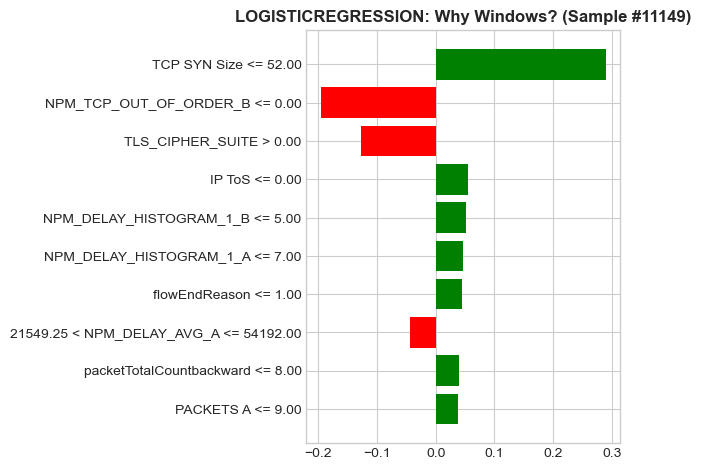


Sample #3844:
  True: iOS  |  Predicted: iOS (61.64%)


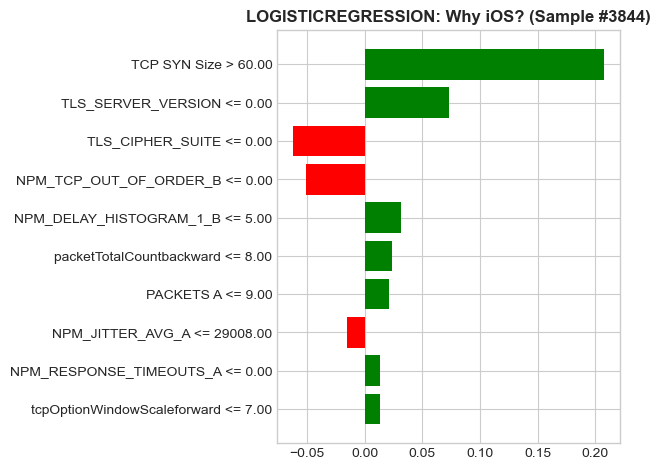


Sample #12033:
  True: Windows  |  Predicted: Windows (98.33%)


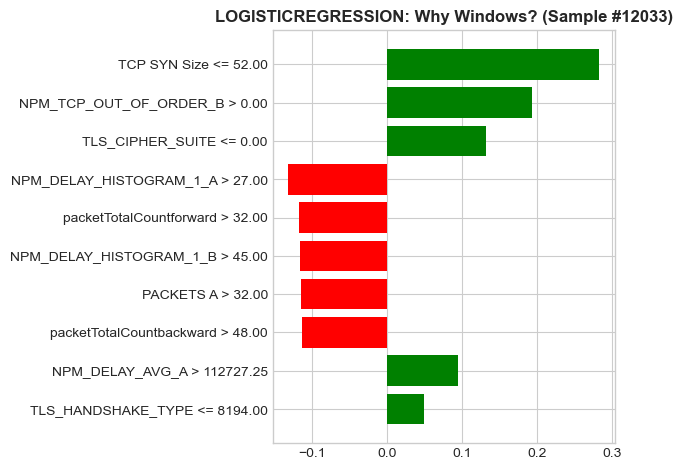


LIME Explanations: RANDOMFOREST

Sample #11149:
  True: Windows  |  Predicted: Windows (100.00%)


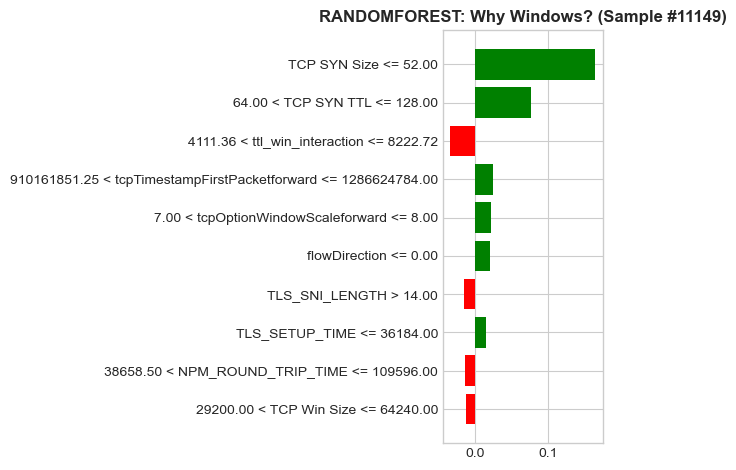


Sample #3844:
  True: iOS  |  Predicted: iOS (98.42%)


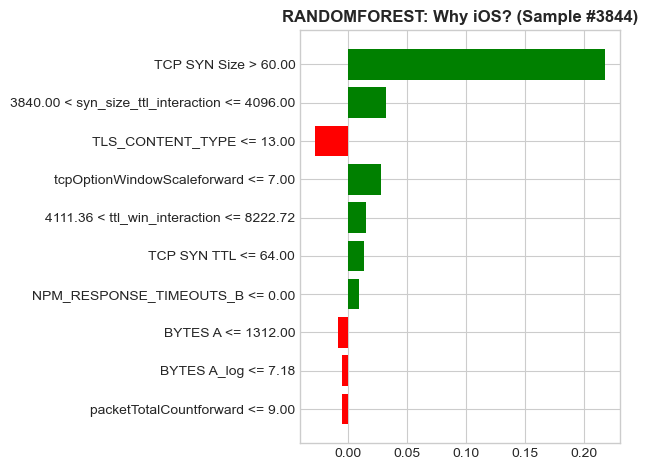


Sample #12033:
  True: Windows  |  Predicted: Windows (99.99%)


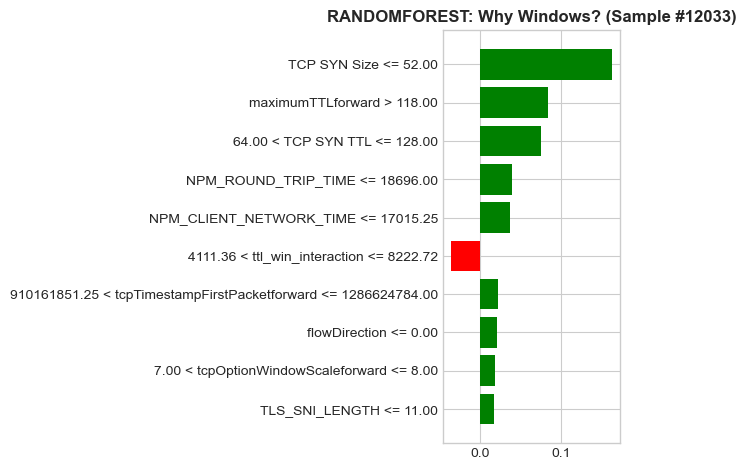


(Skipping remaining models to save time - same process applies)


In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lime.lime_tabular import LimeTabularExplainer

# -----------------------------
# Build test array + feature names
# -----------------------------
if "X_test_df" in globals() and hasattr(X_test_df, "columns"):
    feature_names = list(X_test_df.columns)
    X_test_np = X_test_df.values
elif "X_test_imp" in globals() and "X_train_df" in globals() and hasattr(X_train_df, "columns"):
    feature_names = list(X_train_df.columns)
    X_test_np = np.asarray(X_test_imp)
else:
    raise TypeError("Need X_test_df (preferred) OR X_test_imp + X_train_df.columns to run LIME safely.")

y_test_arr = np.asarray(y_test)

# -----------------------------
# Ensure we have a LIME explainer (recreate for safety/consistency)
# -----------------------------
# Use training distribution if available; otherwise fall back to test distribution
if "X_train_df" in globals() and hasattr(X_train_df, "columns"):
    X_lime_train = X_train_df[feature_names].values
else:
    X_lime_train = X_test_np

lime_explainer = LimeTabularExplainer(
    training_data=X_lime_train,
    feature_names=feature_names,
    class_names=list(le.classes_) if "le" in globals() else None,
    mode="classification",
    discretize_continuous=True
)

# -----------------------------
# Wrapper: LIME gives numpy -> pipeline needs DataFrame (because ColumnTransformer uses column names)
# -----------------------------
def make_predict_proba_df(model_pipeline, feature_names):
    def _predict_proba(X):
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(1, -1)
        X_df = pd.DataFrame(X, columns=feature_names)
        return model_pipeline.predict_proba(X_df)
    return _predict_proba

# Pick 3 random test samples
np.random.seed(42)
n_samples = min(3, X_test_np.shape[0])
sample_indices_lime = np.random.choice(X_test_np.shape[0], size=n_samples, replace=False)

for m_i, (model_name, model_pipeline) in enumerate(loaded_models.items()):
    print(f"\n{'='*70}")
    print(f"LIME Explanations: {model_name.upper()}")
    print(f"{'='*70}")

    predict_fn = make_predict_proba_df(model_pipeline, feature_names)

    for idx in sample_indices_lime:
        sample = X_test_np[idx]  # 1D numpy row for LIME
        true_label = le.classes_[y_test_arr[idx]] if "le" in globals() else y_test_arr[idx]

        try:
            # Explain prediction
            exp = lime_explainer.explain_instance(
                data_row=sample,
                predict_fn=predict_fn,     # <-- FIX: wrapper converts to DataFrame
                num_features=10,
                top_labels=4
            )

            # Get prediction (also via wrapper)
            pred_proba = predict_fn(sample)[0]
            pred_label_idx = int(np.argmax(pred_proba))
            pred_label = le.classes_[pred_label_idx] if "le" in globals() else pred_label_idx

            print(f"\nSample #{idx}:")
            print(f"  True: {true_label}  |  Predicted: {pred_label} ({pred_proba[pred_label_idx]:.2%})")

            fig = exp.as_pyplot_figure(label=pred_label_idx)
            plt.title(f'{model_name.upper()}: Why {pred_label}? (Sample #{idx})',
                      fontsize=12, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'lime_{model_name}_sample_{idx}.png', dpi=300, bbox_inches='tight')
            plt.show()

        except Exception as e:
            print(f"  ✗ Error explaining sample #{idx}: {e}")
            continue

    # Only show LIME for first 2 models to save time
    if m_i >= 1:
        print("\n(Skipping remaining models to save time - same process applies)")
        break


---
## 7. Cross-Model Feature Importance Comparison

CROSS-MODEL FEATURE IMPORTANCE COMPARISON

Top 10 features (averaged across 3 models):
                                LogisticRegression  RandomForest  ExtraTrees  \
feature                                                                        
TCP SYN Size                                100.00        100.00      100.00   
TCP Win Size                                  0.91         16.60       82.22   
tcpOptionWindowScaleforward                   4.29         53.11       11.00   
TLS_HANDSHAKE_TYPE                           35.34          0.23        1.50   
maximumTTLforward                             0.16         23.49        6.64   
tcpTimestampFirstPacketforward                4.25          5.99       15.81   
flowDirection                                 0.32          1.92       19.73   
ttl_win_interaction                           3.07          6.85       10.91   
TLS_SERVER_VERSION                           16.77          0.20        1.67   
TLS_CONTENT_TYPE                 

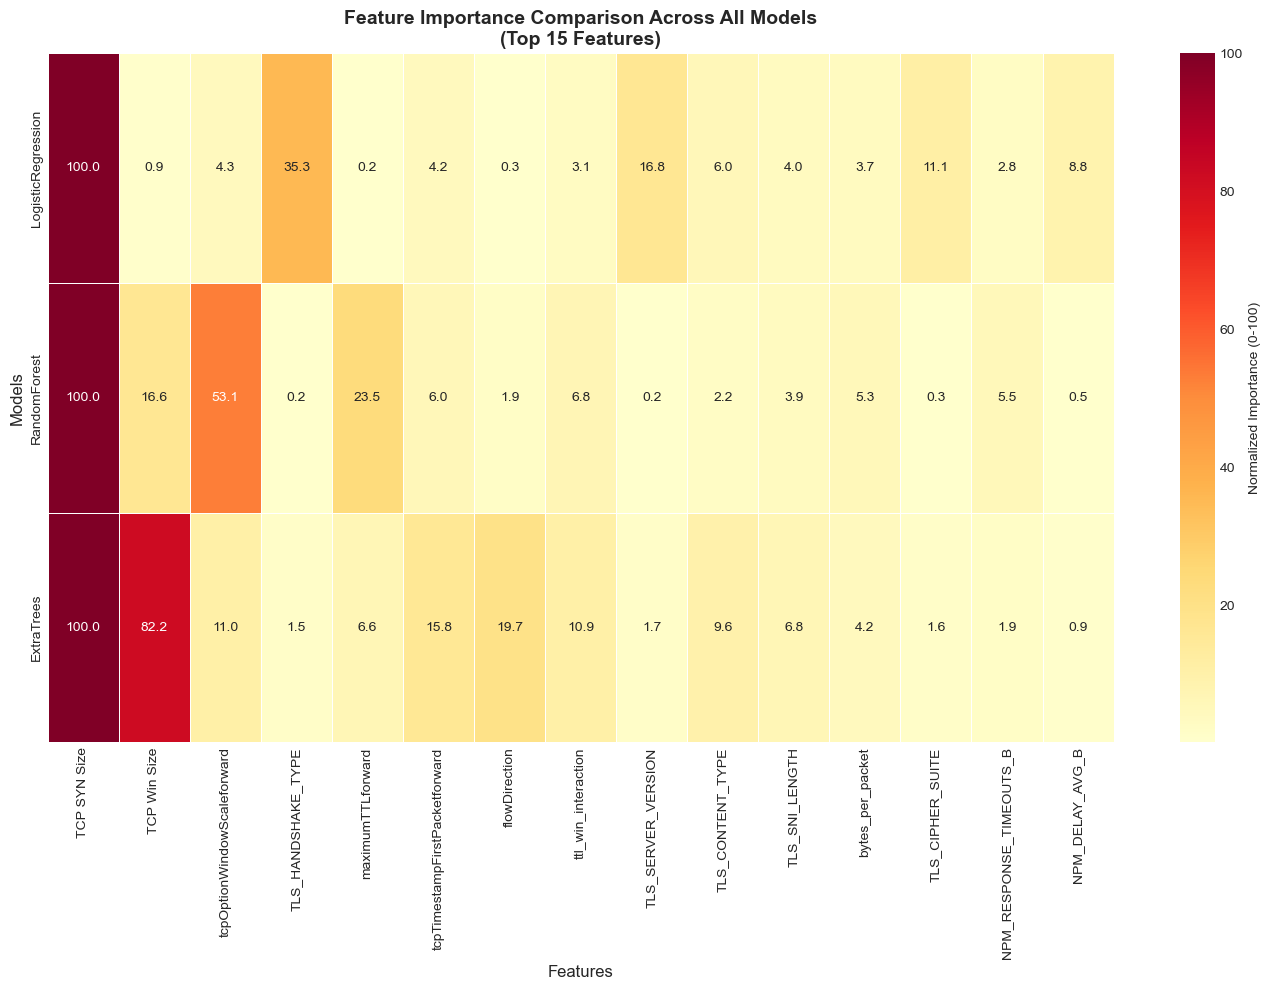

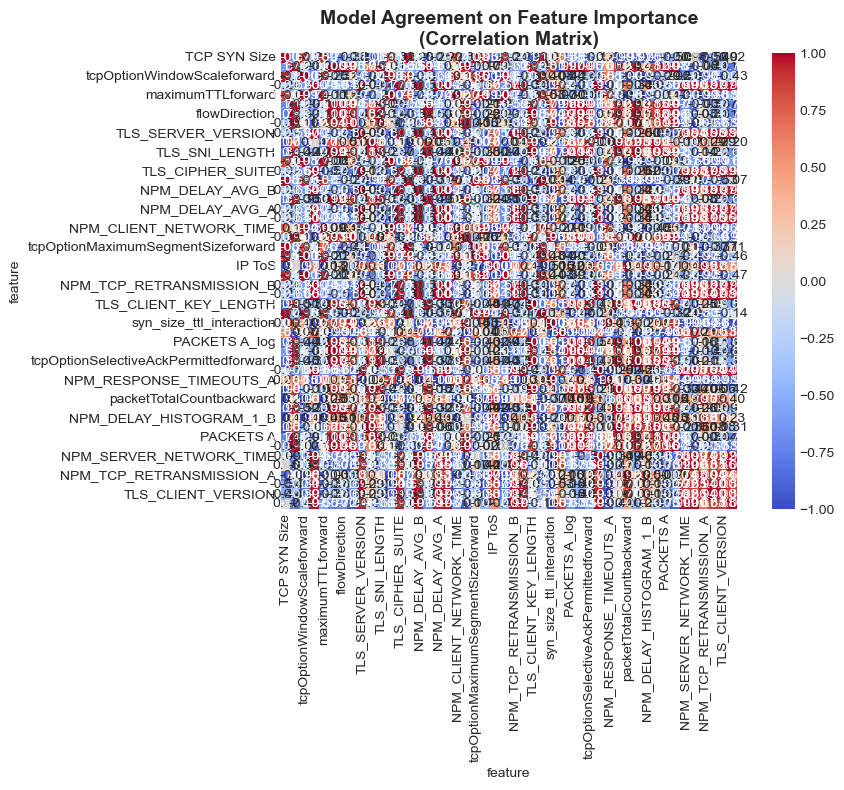


✓ Cross-model comparison complete

Model Agreement (correlation):
feature                                TCP SYN Size  TCP Win Size  \
feature                                                             
TCP SYN Size                                  1.000        -0.674   
TCP Win Size                                 -0.674         1.000   
tcpOptionWindowScaleforward                   0.968        -0.212   
TLS_HANDSHAKE_TYPE                           -0.238        -0.625   
maximumTTLforward                             0.888        -0.068   
tcpTimestampFirstPacketforward               -0.710         0.999   
flowDirection                                -0.762         0.994   
ttl_win_interaction                          -0.375         0.949   
TLS_SERVER_VERSION                           -0.288        -0.586   
TLS_CONTENT_TYPE                             -1.062         0.755   
TLS_SNI_LENGTH                               -0.839         0.977   
bytes_per_packet                    

In [18]:
print("="*70)
print("CROSS-MODEL FEATURE IMPORTANCE COMPARISON")
print("="*70)

# Aggregate importances from permutation
if len(permutation_results) > 1:
    # Create comparison DataFrame
    comparison_data = {}
    for model_name, importance_df in permutation_results.items():
        comparison_data[model_name] = importance_df.set_index('feature')['importance_mean']
    
    comparison_df = pd.DataFrame(comparison_data).fillna(0)
    
    # Normalize to 0-100 scale
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 100))
    comparison_df_norm = pd.DataFrame(
        scaler.fit_transform(comparison_df),
        index=comparison_df.index,
        columns=comparison_df.columns
    )
    
    # Add average
    comparison_df_norm['Average'] = comparison_df_norm.mean(axis=1)
    comparison_df_norm = comparison_df_norm.sort_values('Average', ascending=False)
    
    print(f"\nTop 10 features (averaged across {len(permutation_results)} models):")
    print(comparison_df_norm.head(10).round(2))
    
    # Heatmap
    plt.figure(figsize=(14, 10))
    top_15 = comparison_df_norm.head(15)
    model_cols = [c for c in top_15.columns if c != 'Average']
    
    sns.heatmap(
        top_15[model_cols].T,
        annot=True,
        fmt='.1f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Normalized Importance (0-100)'},
        linewidths=0.5
    )
    plt.title('Feature Importance Comparison Across All Models\n(Top 15 Features)',
             fontsize=14, fontweight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Models', fontsize=12)
    plt.tight_layout()
    plt.savefig('feature_importance_heatmap_all_models.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Correlation between models
    correlation = comparison_df_norm[model_cols].T.corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        correlation,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        square=True
    )
    plt.title('Model Agreement on Feature Importance\n(Correlation Matrix)',
             fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('model_agreement_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Cross-model comparison complete")
    print(f"\nModel Agreement (correlation):")
    print(correlation.round(3))

---
## 8. Summary & Key Findings

In [19]:
print("\n" + "="*70)
print("EXPLAINABILITY ANALYSIS SUMMARY")
print("="*70)

print("\n1. MODELS ANALYZED:")
for i, model_name in enumerate(loaded_models.keys(), 1):
    print(f"   {i}. {model_name}")

print("\n2. METHODS USED:")
print("   ✓ Permutation Importance (all models)")
if logistic_model:
    print("   ✓ Coefficient Analysis (LogisticRegression)")
if len(shap_results) > 0:
    print(f"   ✓ SHAP TreeExplainer ({len(shap_results)} tree models)")
print("   ✓ LIME (local explanations)")

print("\n3. KEY FINDINGS:")
if len(permutation_results) > 0:
    # Get consensus top features
    if 'comparison_df_norm' in locals():
        top_3 = comparison_df_norm.head(3)
        print("   Top 3 features (consensus across models):")
        for i, (feat, row) in enumerate(top_3.iterrows(), 1):
            print(f"     {i}. {feat} (avg importance: {row['Average']:.1f})")

print("\n4. VISUALIZATIONS GENERATED:")
viz_count = 0
viz_files = [
    'permutation_importance_all_models.png',
    'feature_importance_heatmap_all_models.png',
    'model_agreement_correlation.png'
]
for f in viz_files:
    if os.path.exists(f):
        viz_count += 1
        print(f"   ✓ {f}")

# Count SHAP plots
shap_count = len([f for f in os.listdir('.') if f.startswith('shap_') and f.endswith('.png')])
lime_count = len([f for f in os.listdir('.') if f.startswith('lime_') and f.endswith('.png')])
logistic_count = len([f for f in os.listdir('.') if f.startswith('logistic_') and f.endswith('.png')])

print(f"   ✓ {shap_count} SHAP plots")
print(f"   ✓ {lime_count} LIME plots")
print(f"   ✓ {logistic_count} Logistic coefficient plots")

total_viz = viz_count + shap_count + lime_count + logistic_count
print(f"\n   Total: {total_viz} visualizations")

print("\n5. NEXT STEPS:")
print("   → Use insights for adversarial attack design")
print("   → Identify which features are most manipulable")
print("   → Compare basic models vs complex models (CatBoost, etc.)")
print("   → Document findings in project report")

print("\n" + "="*70)
print("✓ EXPLAINABILITY ANALYSIS COMPLETE")
print("="*70)


EXPLAINABILITY ANALYSIS SUMMARY

1. MODELS ANALYZED:
   1. LogisticRegression
   2. RandomForest
   3. ExtraTrees

2. METHODS USED:
   ✓ Permutation Importance (all models)
   ✓ Coefficient Analysis (LogisticRegression)
   ✓ SHAP TreeExplainer (2 tree models)
   ✓ LIME (local explanations)

3. KEY FINDINGS:
   Top 3 features (consensus across models):
     1. TCP SYN Size (avg importance: 100.0)
     2. TCP Win Size (avg importance: 33.2)
     3. tcpOptionWindowScaleforward (avg importance: 22.8)

4. VISUALIZATIONS GENERATED:
   ✓ permutation_importance_all_models.png
   ✓ feature_importance_heatmap_all_models.png
   ✓ model_agreement_correlation.png
   ✓ 4 SHAP plots
   ✓ 6 LIME plots
   ✓ 5 Logistic coefficient plots

   Total: 18 visualizations

5. NEXT STEPS:
   → Use insights for adversarial attack design
   → Identify which features are most manipulable
   → Compare basic models vs complex models (CatBoost, etc.)
   → Document findings in project report

✓ EXPLAINABILITY ANALYSI